In [1]:
import numpy as np
import scipy.integrate
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
import copy

from miou.metrics import miou
from miou.metrics.iou import IoU
from miou.utils.mask_loader import load_mask
from miou.utils.segmentation import GridBasedSegmentation
from scipy.stats import linregress
from miou.edge_detection import sobel
from scipy.integrate import trapezoid, simpson
import matplotlib.pyplot as plt 


In [2]:
def pre_process_masks(mask1, mask2, scale):  # This is the function s in the paper
    preprocessor1 = GridBasedSegmentation(mask1, scale)
    s1 = preprocessor1.segmentize()
    preprocessor2 = GridBasedSegmentation(mask2, scale)
    s2 = preprocessor2.segmentize()

    return s1, s2

In [3]:
def calculate_bce_with_logits(gt, prediction, scale):
    loss = nn.BCEWithLogitsLoss()
    l = loss(prediction, gt)
    return l

In [4]:
def calculate_bce(gt, prediction, scale):
    # print(prediction)
    # print(gt)
    loss = nn.BCELoss()
    l = loss(prediction, gt)
    l = torch.sigmoid(l)
    # print(l)
    # print("-------------------------------------------------------------")
    return l

In [5]:
def calculate_area(distances, scales):
    b = copy.deepcopy(scales).reshape((-1, 1))
    normalized_scales = MinMaxScaler().fit_transform(b)
    normalized_scales = normalized_scales.reshape(-1)
    # distances = np.array(distances)
    print(f'distances after conversion:{distances}')
    area = simpson(distances, normalized_scales)
    return area

In [6]:
gt = load_mask("./test_images/test_segm_input_B/mask1.png")
img2 = load_mask("./test_images/test_segm_input_B/mask2.png")
img3 = load_mask("./test_images/test_segm_input_B/mask3.png")
# img2 = load_mask("./test_images/test_segm_input_B/mask1.png")
masks = [gt, img2, img3]

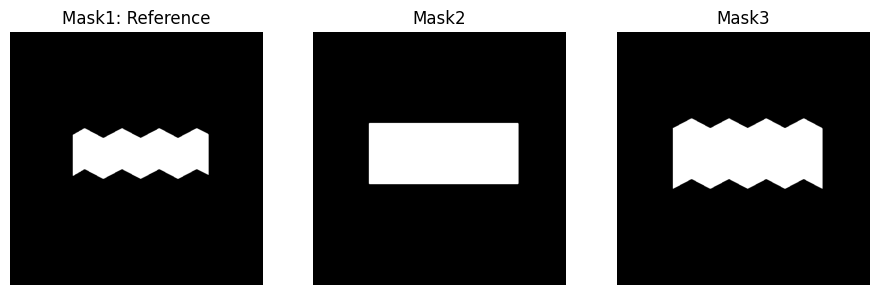

In [7]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [8]:
scales = np.power(2, np.linspace(0, 9, num=10, dtype=int))

In [9]:
def MCE(gt, img2, detect_edges = True):

    distances = []
    box_counting_m1 = []
    box_counting_m2 = []
    box_counting_distance = []
    
    if detect_edges:
        gt = sobel.get_edges(gt)
        img2 = sobel.get_edges(img2)
        
    for scale in scales:
        s_gt, s_img2 = pre_process_masks(gt, img2, scale)
        box_counting_m1.append(np.sum(s_gt) + 1)
        box_counting_m2.append(np.sum(s_img2) + 1)
        # distance = calculate_ce(torch.from_numpy(s_gt.astype(float)), torch.from_numpy(s_img2.astype(float)), scale)
        # distance = calculate_ce(
        #     torch.tensor(box_counting_m1[-1], dtype=torch.float),
        #     torch.tensor(box_counting_m2[-1], dtype=torch.float),
        #     scale)
        distance = calculate_bce_with_logits(
            torch.tensor(s_gt, dtype=torch.float),
            torch.tensor(s_img2, dtype=torch.float),
            scale)
        # distance = calculate_bce(
        #     torch.tensor(s_gt, dtype=torch.float),
        #     torch.tensor(s_img2, dtype=torch.float),
        #     scale)
        box_counting_distance.append(torch.sum(distance))
        # print(f"box_counting_1: {box_counting_m1}")
        # print(f"box_counting_2: {box_counting_m2}")
        distances.append(distance)

    print(f"distances: {distances}")
    mce = calculate_area(distances, scales)
    
    print(f"mce: {mce}")
    return mce



In [10]:
mce_gt_img2 = MCE(gt, img2)

distances: [tensor(0.6972), tensor(0.7006), tensor(0.7080), tensor(0.7171), tensor(0.7164), tensor(0.7096), tensor(0.7038), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6972), tensor(0.7006), tensor(0.7080), tensor(0.7171), tensor(0.7164), tensor(0.7096), tensor(0.7038), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
mce: 0.39450183247037235


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [11]:
mce_gt_img3 = MCE(gt, img3)

distances: [tensor(0.6986), tensor(0.7013), tensor(0.7073), tensor(0.7186), tensor(0.7182), tensor(0.7013), tensor(0.6801), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6986), tensor(0.7013), tensor(0.7073), tensor(0.7186), tensor(0.7182), tensor(0.7013), tensor(0.6801), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
mce: 0.3933943966583833


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [12]:
mce_gt_img2

0.39450183247037235

In [13]:
mce_gt_img3

0.3933943966583833

In [14]:
mce_gt_img2_no_edge = MCE(gt, img2, detect_edges = False)

distances: [tensor(0.6949), tensor(0.6933), tensor(0.6888), tensor(0.6824), tensor(0.6776), tensor(0.6619), tensor(0.6801), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6949), tensor(0.6933), tensor(0.6888), tensor(0.6824), tensor(0.6776), tensor(0.6619), tensor(0.6801), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
mce: 0.38968305291365374


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [15]:
mce_gt_img3_no_edge = MCE(gt, img3, detect_edges = False)

distances: [tensor(0.6942), tensor(0.6937), tensor(0.6915), tensor(0.6867), tensor(0.6782), tensor(0.6619), tensor(0.6801), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6942), tensor(0.6937), tensor(0.6915), tensor(0.6867), tensor(0.6782), tensor(0.6619), tensor(0.6801), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
mce: 0.3897671020239637


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [16]:
print(mce_gt_img2_no_edge)
print(mce_gt_img2)

0.38968305291365374
0.39450183247037235


In [17]:
print(mce_gt_img3_no_edge)
print(mce_gt_img3)

0.3897671020239637
0.3933943966583833


In [18]:
mce_gt_gt = MCE(gt, gt, detect_edges = False)

distances: [tensor(0.6601), tensor(0.6593), tensor(0.6576), tensor(0.6541), tensor(0.6479), tensor(0.6353), tensor(0.6219), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6601), tensor(0.6593), tensor(0.6576), tensor(0.6541), tensor(0.6479), tensor(0.6353), tensor(0.6219), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
mce: 0.3855724636692927


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [19]:
# Example2: Solar filament

In [20]:
mask1 = load_mask('./test_images/test_segm_input_Z2/mask1.png')
mask2 = load_mask('./test_images/test_segm_input_Z2/mask2.png')
mask3 = load_mask('./test_images/test_segm_input_Z2/mask3.png')
masks = [mask1, mask2, mask3]

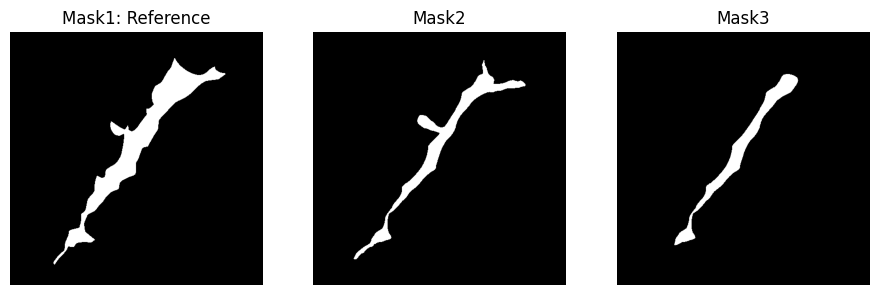

In [21]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [22]:
mce_f1_f2 = MCE(mask1, mask2)

distances: [tensor(0.7000), tensor(0.7027), tensor(0.7058), tensor(0.7041), tensor(0.6838), tensor(0.6461), tensor(0.5982), tensor(0.5269), tensor(0.4082), tensor(0.3133)]
distances after conversion:[tensor(0.7000), tensor(0.7027), tensor(0.7058), tensor(0.7041), tensor(0.6838), tensor(0.6461), tensor(0.5982), tensor(0.5269), tensor(0.4082), tensor(0.3133)]
mce: 0.43974524613605115


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [23]:
mce_f1_f2_no_edge = MCE(mask1, mask2, detect_edges=False)

distances: [tensor(0.6846), tensor(0.6837), tensor(0.6815), tensor(0.6760), tensor(0.6672), tensor(0.6461), tensor(0.5982), tensor(0.5269), tensor(0.4082), tensor(0.3133)]
distances after conversion:[tensor(0.6846), tensor(0.6837), tensor(0.6815), tensor(0.6760), tensor(0.6672), tensor(0.6461), tensor(0.5982), tensor(0.5269), tensor(0.4082), tensor(0.3133)]
mce: 0.43903248040902665


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [24]:
mce_f1_f3 = MCE(mask1, mask3)

distances: [tensor(0.6986), tensor(0.7009), tensor(0.7038), tensor(0.7032), tensor(0.6861), tensor(0.6540), tensor(0.6219), tensor(0.5507), tensor(0.4082), tensor(0.3133)]
distances after conversion:[tensor(0.6986), tensor(0.7009), tensor(0.7038), tensor(0.7032), tensor(0.6861), tensor(0.6540), tensor(0.6219), tensor(0.5507), tensor(0.4082), tensor(0.3133)]
mce: 0.44489785111593305


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [25]:
mce_f1_f3_no_edge = MCE(mask1, mask3, detect_edges=False)

distances: [tensor(0.6814), tensor(0.6806), tensor(0.6788), tensor(0.6751), tensor(0.6683), tensor(0.6516), tensor(0.6219), tensor(0.5507), tensor(0.4082), tensor(0.3133)]
distances after conversion:[tensor(0.6814), tensor(0.6806), tensor(0.6788), tensor(0.6751), tensor(0.6683), tensor(0.6516), tensor(0.6219), tensor(0.5507), tensor(0.4082), tensor(0.3133)]
mce: 0.44400086268299843


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [26]:
mce_f1_f1 = MCE(mask1, mask1)

distances: [tensor(0.6881), tensor(0.6857), tensor(0.6807), tensor(0.6715), tensor(0.6527), tensor(0.6264), tensor(0.5922), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6881), tensor(0.6857), tensor(0.6807), tensor(0.6715), tensor(0.6527), tensor(0.6264), tensor(0.5922), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
mce: 0.38473366116357643


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [27]:
mce_f1_f1_no_edge = MCE(mask1, mask1, detect_edges=False)

distances: [tensor(0.6670), tensor(0.6656), tensor(0.6631), tensor(0.6578), tensor(0.6475), tensor(0.6264), tensor(0.5922), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6670), tensor(0.6656), tensor(0.6631), tensor(0.6578), tensor(0.6475), tensor(0.6264), tensor(0.5922), tensor(0.5032), tensor(0.3133), tensor(0.3133)]
mce: 0.38434720523436705


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [28]:
miou_obj = miou.MIoU(scales, edge_only=True)
miou_obj_no_edge = miou.MIoU(scales, edge_only=False)

In [29]:
print('-----------------------resuts-----------------------')
print('=========example1: gt, img2===============')
print(f'mce: {mce_gt_img2}')
print(f'mce without edge detection: {mce_gt_img2_no_edge}')
print(f'MioU:{miou_obj.measure(gt, img2)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(gt, img2)}')
print('=========example1: gt, img3===============')
print(f'mce: {mce_gt_img3}')
print(f'mce without edge detection: {mce_gt_img3_no_edge}')
print(f'MioU:{miou_obj.measure(gt, img3)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(gt, img3)}')
print('=========example2: mask1, mask1===============')
print(f'mce: {mce_f1_f1}')
print(f'mce without edge detection: {mce_f1_f1_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask1)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask1)}')
print('=========example2: mask1, mask2===============')
print(f'mce: {mce_f1_f2}')
print(f'mce without edge detection: {mce_f1_f2_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask2)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask2)}')
print('=========example2: mask1, mask3===============')
print(f'mce: {mce_f1_f3}')
print(f'mce without edge detection: {mce_f1_f3_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask3)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask3)}')

-----------------------resuts-----------------------
=========example1: gt, img2===============
mce: 0.39450183247037235
mce without edge detection: 0.38968305291365374
MioU:0.43646410763160254
MioU without edge detection:1.0
=========example1: gt, img3===============
mce: 0.3933943966583833
mce without edge detection: 0.3897671020239637
MioU:0.501124778635557
MioU without edge detection:1.0
=========example2: mask1, mask1===============
mce: 0.38473366116357643
mce without edge detection: 0.38434720523436705
MioU:1.0
MioU without edge detection:1.0
=========example2: mask1, mask2===============
mce: 0.43974524613605115
mce without edge detection: 0.43903248040902665
MioU:0.5931655063539093
MioU without edge detection:0.7207830905399536
=========example2: mask1, mask3===============
mce: 0.44489785111593305
mce without edge detection: 0.44400086268299843
MioU:0.4809574598992603
MioU without edge detection:0.6280702813082769


In [30]:
# Example3: Leaf Example

In [31]:
mask1 = load_mask('./test_images/test_segm_input_Z3/mask1.png')
mask2 = load_mask('./test_images/test_segm_input_Z3/mask2.png')
mask3 = load_mask('./test_images/test_segm_input_Z3/mask3.png')
masks = [mask1, mask2, mask3]

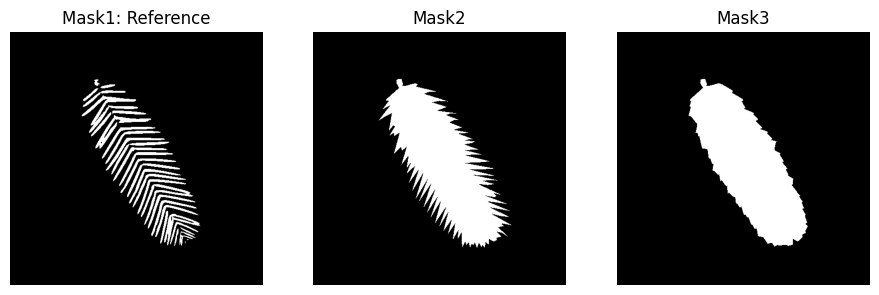

In [32]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [33]:
mce_L1_L1 = MCE(mask1, mask1)

distances: [tensor(0.6669), tensor(0.6548), tensor(0.6404), tensor(0.6309), tensor(0.6223), tensor(0.6056), tensor(0.5804), tensor(0.5269), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6669), tensor(0.6548), tensor(0.6404), tensor(0.6309), tensor(0.6223), tensor(0.6056), tensor(0.5804), tensor(0.5269), tensor(0.3133), tensor(0.3133)]
mce: 0.3859495178114515


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [34]:
mce_L1_L1_no_edge = MCE(mask1, mask1, detect_edges=False)

distances: [tensor(0.6678), tensor(0.6611), tensor(0.6482), tensor(0.6346), tensor(0.6260), tensor(0.6100), tensor(0.5863), tensor(0.5269), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6678), tensor(0.6611), tensor(0.6482), tensor(0.6346), tensor(0.6260), tensor(0.6100), tensor(0.5863), tensor(0.5269), tensor(0.3133), tensor(0.3133)]
mce: 0.38652887268412706


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [35]:
mce_L1_L2 = MCE(mask1, mask2)

distances: [tensor(0.7044), tensor(0.7052), tensor(0.7025), tensor(0.6920), tensor(0.6774), tensor(0.6448), tensor(0.5997), tensor(0.6045), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.7044), tensor(0.7052), tensor(0.7025), tensor(0.6920), tensor(0.6774), tensor(0.6448), tensor(0.5997), tensor(0.6045), tensor(0.3133), tensor(0.3133)]
mce: 0.4040942865691773


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [36]:
mce_L1_L2_no_edge = MCE(mask1, mask2, detect_edges=False)

distances: [tensor(0.7197), tensor(0.7070), tensor(0.6814), tensor(0.6578), tensor(0.6514), tensor(0.6318), tensor(0.6154), tensor(0.6045), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.7197), tensor(0.7070), tensor(0.6814), tensor(0.6578), tensor(0.6514), tensor(0.6318), tensor(0.6154), tensor(0.6045), tensor(0.3133), tensor(0.3133)]
mce: 0.4027695654073107


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [37]:
mce_L1_L3 = MCE(mask1, mask3)

distances: [tensor(0.6961), tensor(0.6960), tensor(0.6940), tensor(0.6859), tensor(0.6702), tensor(0.6416), tensor(0.6019), tensor(0.5657), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6961), tensor(0.6960), tensor(0.6940), tensor(0.6859), tensor(0.6702), tensor(0.6416), tensor(0.6019), tensor(0.5657), tensor(0.3133), tensor(0.3133)]
mce: 0.3971094686030097


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [38]:
mce_L1_L3_no_edge = MCE(mask1, mask3, detect_edges=False)

distances: [tensor(0.7201), tensor(0.7041), tensor(0.6730), tensor(0.6436), tensor(0.6342), tensor(0.6212), tensor(0.5960), tensor(0.5269), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.7201), tensor(0.7041), tensor(0.6730), tensor(0.6436), tensor(0.6342), tensor(0.6212), tensor(0.5960), tensor(0.5269), tensor(0.3133), tensor(0.3133)]
mce: 0.3879757839509989


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


In [39]:
print('-----------------------resuts-----------------------')
print('=========example3: gt, gt===============')
print(f'mce: {mce_L1_L1}')
print(f'mce without edge detection: {mce_L1_L1_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask1)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask1)}')
print('=========example3: gt, mask2===============')
print(f'mce: {mce_L1_L2}')
print(f'mce without edge detection: {mce_L1_L2_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask2)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask2)}')
print('=========example2: mask1, mask3===============')
print(f'mce: {mce_L1_L3}')
print(f'mce without edge detection: {mce_L1_L3_no_edge}')
print(f'MioU:{miou_obj.measure(mask1, mask3)}')
print(f'MioU without edge detection:{miou_obj_no_edge.measure(mask1, mask3)}')

-----------------------resuts-----------------------
=========example3: gt, gt===============
mce: 0.3859495178114515
mce without edge detection: 0.38652887268412706
MioU:1.0
MioU without edge detection:1.0
=========example3: gt, mask2===============
mce: 0.4040942865691773
mce without edge detection: 0.4027695654073107
MioU:0.6129562121025678
MioU without edge detection:0.9992155600159403
=========example2: mask1, mask3===============
mce: 0.3971094686030097
mce without edge detection: 0.3879757839509989
MioU:0.5386056072966319
MioU without edge detection:0.9968354374046466


In [40]:
# Example4: Synthetic Regions

In [41]:
import os
path = './test_images/test_segm_input_F/'

all_paths = [os.path.join(path, f) for f in os.listdir(path) if f.startswith('mask')]
all_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

all_masks = []
for p in all_paths:
    all_masks.append(load_mask(p))

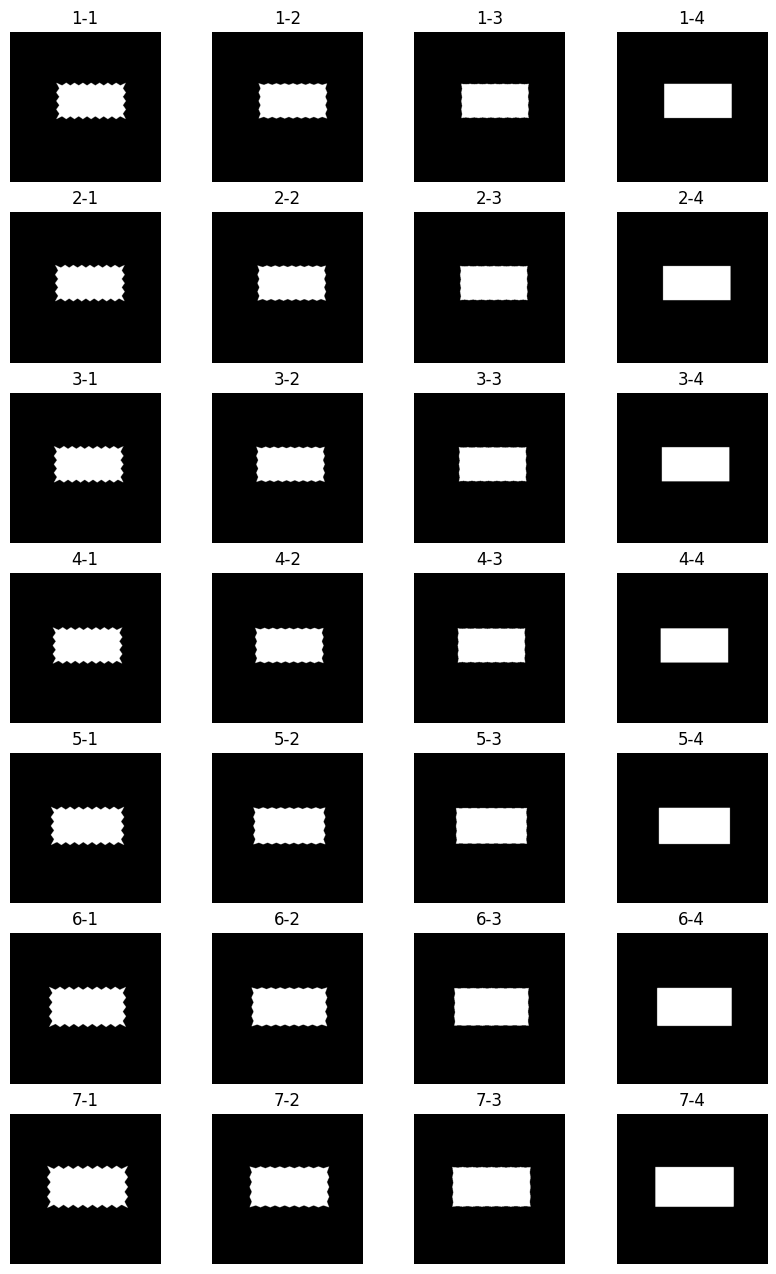

In [42]:
n_rows, n_cols = 7, 4
fig = plt.figure(figsize=(10, 16))
all_axes = []
j = 0
for i in range(len(all_paths)):
    all_axes.append(fig.add_subplot(n_rows, n_cols, i+1))

labels = []
for ax in all_axes:
    ax.axis('off')
    title = '{}-{}'.format(all_paths[j][-7], all_paths[j][-5])
    labels.append(title)
    ax.set_title(title, fontsize= 12)
    ax.imshow(all_masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [43]:
ref_idx = 12   # index of reference object (i.e. ground truth)
gt = all_masks[ref_idx]

In [44]:
mce = []
mce_no_edge = []
ious = []
miou = []
iou = IoU()
for i, mask in enumerate(all_masks):
    mce_gt_mask = MCE(gt, mask)
    mce.append(mce_gt_mask)
    mce_gt_mask_no_edges = MCE(gt, mask, detect_edges=False)
    mce_no_edge.append(mce_gt_mask_no_edges)
    print(f'index: {i}')
    print(f'mce_gt_mask: {mce_gt_mask}')
    # print(f'mce_gt_mask: {mce_gt_mask_no_edges}')
    print('------------------------')
    ious.append(iou.measure(gt, mask))
    miou.append(miou_obj.measure(gt, mask))
measures_list=[ious, miou, mce]

distances: [tensor(0.6984), tensor(0.7010), tensor(0.7050), tensor(0.7055), tensor(0.6934), tensor(0.6760), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6984), tensor(0.7010), tensor(0.7050), tensor(0.7055), tensor(0.6934), tensor(0.6760), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4202305277739434
distances: [tensor(0.6707), tensor(0.6701), tensor(0.6688), tensor(0.6656), tensor(0.6557), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6707), tensor(0.6701), tensor(0.6688), tensor(0.6656), tensor(0.6557), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.41672040350697925
index: 0
mce_gt_mask: 0.4202305277739434
------------------------
distances: [tensor(0.6976), tensor(0.6998), tensor(0.7036), tensor(0.7038), tensor(0.6886), tensor(0.6804), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6706), tensor(0.6700), tensor(0.6686), tensor(0.6650), tensor(0.6538), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6706), tensor(0.6700), tensor(0.6686), tensor(0.6650), tensor(0.6538), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4166984392245403
index: 1
mce_gt_mask: 0.4206192371611441
------------------------
distances: [tensor(0.6968), tensor(0.6988), tensor(0.7024), tensor(0.7051), tensor(0.6890), tensor(0.6804), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6968), tensor(0.6988), tensor(0.7024), tensor(0.7051), tensor(0.6890), tensor(0.6804), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4206364251694282
distances: [tensor(0.6708), tensor(0.6701), tensor(0.6684), tensor(0.6662), tensor(0.6564), tensor(0.6533), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6964), tensor(0.6969), tensor(0.7004), tensor(0.7050), tensor(0.6883), tensor(0.6804), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6964), tensor(0.6969), tensor(0.7004), tensor(0.7050), tensor(0.6883), tensor(0.6804), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4206190590470686
distances: [tensor(0.6711), tensor(0.6707), tensor(0.6703), tensor(0.6662), tensor(0.6564), tensor(0.6533), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6711), tensor(0.6707), tensor(0.6703), tensor(0.6662), tensor(0.6564), tensor(0.6533), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4172629905954914
index: 3
mce_gt_mask: 0.4206190590470686
------------------------
distances: [tensor(0.6982), tensor(0.6998), tensor(0.7011), tensor(0.6999), tensor(0.6860), tensor(0.6760), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances after conversion:[tensor(0.6982), tensor(0.6998), tensor(0.7011), tensor(0.6999), tensor(0.6860), tensor(0.6760), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.42007784805600606
distances: [tensor(0.6660), tensor(0.6654), tensor(0.6640), tensor(0.6613), tensor(0.6535), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6660), tensor(0.6654), tensor(0.6640), tensor(0.6613), tensor(0.6535), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4166030584372601
index: 4
mce_gt_mask: 0.42007784805600606
------------------------
distances: [tensor(0.6976), tensor(0.6993), tensor(0.7008), tensor(0.6990), tensor(0.6854), tensor(0.6760), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6976), tensor(0.6993), tensor(0.7008), tensor(0.6990), tensor(0.6854), tensor(0.6760), tensor(0.6629), tensor(0.6757), tensor(0

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6968), tensor(0.6987), tensor(0.7006), tensor(0.6968), tensor(0.6834), tensor(0.6726), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6968), tensor(0.6987), tensor(0.7006), tensor(0.6968), tensor(0.6834), tensor(0.6726), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4197653290641699
distances: [tensor(0.6660), tensor(0.6652), tensor(0.6634), tensor(0.6597), tensor(0.6529), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6660), tensor(0.6652), tensor(0.6634), tensor(0.6597), tensor(0.6529), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.4165695781525282
index: 6
mce_gt_mask: 0.4197653290641699
------------------------
distances: [tensor(0.6963), tensor(0.6966), tensor(0.6994), tensor(0.6989), tensor(0.6856), tensor(0.6771), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.3

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6963), tensor(0.6966), tensor(0.6947), tensor(0.6875), tensor(0.6737), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6963), tensor(0.6966), tensor(0.6947), tensor(0.6875), tensor(0.6737), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.40477671198000925
distances: [tensor(0.6609), tensor(0.6601), tensor(0.6584), tensor(0.6541), tensor(0.6449), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6609), tensor(0.6601), tensor(0.6584), tensor(0.6541), tensor(0.6449), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.4016443009181083
index: 9
mce_gt_mask: 0.40477671198000925
------------------------
distances: [tensor(0.6956), tensor(0.6957), tensor(0.6946), tensor(0.6894), tensor(0.6785), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6898), tensor(0.6882), tensor(0.6851), tensor(0.6799), tensor(0.6675), tensor(0.6516), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6898), tensor(0.6882), tensor(0.6851), tensor(0.6799), tensor(0.6675), tensor(0.6516), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.40364945686545206
distances: [tensor(0.6558), tensor(0.6550), tensor(0.6533), tensor(0.6503), tensor(0.6431), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6558), tensor(0.6550), tensor(0.6533), tensor(0.6503), tensor(0.6431), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.4015372064184121
index: 12
mce_gt_mask: 0.40364945686545206
------------------------
distances: [tensor(0.6923), tensor(0.6906), tensor(0.6875), tensor(0.6812), tensor(0.6679), tensor(0.6516), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6945), tensor(0.6938), tensor(0.6915), tensor(0.6867), tensor(0.6768), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6945), tensor(0.6938), tensor(0.6915), tensor(0.6867), tensor(0.6768), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.4047637305607819
distances: [tensor(0.6595), tensor(0.6587), tensor(0.6565), tensor(0.6530), tensor(0.6431), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6595), tensor(0.6587), tensor(0.6565), tensor(0.6530), tensor(0.6431), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.4016061347284947
index: 15
mce_gt_mask: 0.4047637305607819
------------------------
distances: [tensor(0.6971), tensor(0.6977), tensor(0.6962), tensor(0.6925), tensor(0.6827), tensor(0.6637), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6958), tensor(0.6963), tensor(0.6952), tensor(0.6902), tensor(0.6823), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6958), tensor(0.6963), tensor(0.6952), tensor(0.6902), tensor(0.6823), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.40487434587535137
distances: [tensor(0.6629), tensor(0.6619), tensor(0.6596), tensor(0.6547), tensor(0.6479), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6629), tensor(0.6619), tensor(0.6596), tensor(0.6547), tensor(0.6479), tensor(0.6338), tensor(0.6219), tensor(0.5982), tensor(0.3133), tensor(0.3133)]
mce: 0.401682699023446
index: 18
mce_gt_mask: 0.40487434587535137
------------------------
distances: [tensor(0.6959), tensor(0.6970), tensor(0.6968), tensor(0.6951), tensor(0.6849), tensor(0.6605), tensor(0.6338), tensor(0.5982), tensor(0.3133), tensor(0

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6978), tensor(0.6995), tensor(0.7022), tensor(0.7027), tensor(0.6914), tensor(0.6726), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6978), tensor(0.6995), tensor(0.7022), tensor(0.7027), tensor(0.6914), tensor(0.6726), tensor(0.6629), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.41992248630401857
distances: [tensor(0.6695), tensor(0.6687), tensor(0.6667), tensor(0.6635), tensor(0.6540), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6695), tensor(0.6687), tensor(0.6667), tensor(0.6635), tensor(0.6540), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.416662842829115
index: 21
mce_gt_mask: 0.41992248630401857
------------------------
distances: [tensor(0.6969), tensor(0.6982), tensor(0.7004), tensor(0.7018), tensor(0.6929), tensor(0.6771), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6991), tensor(0.7018), tensor(0.7063), tensor(0.7122), tensor(0.7056), tensor(0.7134), tensor(0.7560), tensor(0.7532), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6991), tensor(0.7018), tensor(0.7063), tensor(0.7122), tensor(0.7056), tensor(0.7134), tensor(0.7560), tensor(0.7532), tensor(0.3133), tensor(0.3133)]
mce: 0.4384633873267961
distances: [tensor(0.6769), tensor(0.6764), tensor(0.6753), tensor(0.6738), tensor(0.6630), tensor(0.6822), tensor(0.7382), tensor(0.7532), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6769), tensor(0.6764), tensor(0.6753), tensor(0.6738), tensor(0.6630), tensor(0.6822), tensor(0.7382), tensor(0.7532), tensor(0.3133), tensor(0.3133)]
mce: 0.4347656347533106
index: 24
mce_gt_mask: 0.4384633873267961
------------------------
distances: [tensor(0.6984), tensor(0.7009), tensor(0.7050), tensor(0.7111), tensor(0.7020), tensor(0.7134), tensor(0.7560), tensor(0.7532), tensor(0.3133), tensor(0.

/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional

distances: [tensor(0.6969), tensor(0.6995), tensor(0.7020), tensor(0.7083), tensor(0.6929), tensor(0.6771), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6969), tensor(0.6995), tensor(0.7020), tensor(0.7083), tensor(0.6929), tensor(0.6771), tensor(0.6688), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.42048196763506557
distances: [tensor(0.6797), tensor(0.6783), tensor(0.6771), tensor(0.6730), tensor(0.6540), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
distances after conversion:[tensor(0.6797), tensor(0.6783), tensor(0.6771), tensor(0.6730), tensor(0.6540), tensor(0.6459), tensor(0.6510), tensor(0.6757), tensor(0.3133), tensor(0.3133)]
mce: 0.41688850688905815
index: 27
mce_gt_mask: 0.42048196763506557
------------------------


/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)
/tmp/ipykernel_13605/3172179598.py:7: DeprecationWarning: You are passing x=[0.         0.00195695 0.00587084 0.01369863 0.02935421 0.06066536
 0.12328767 0.24853229 0.49902153 1.        ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  area = simpson(distances, normalized_scales)


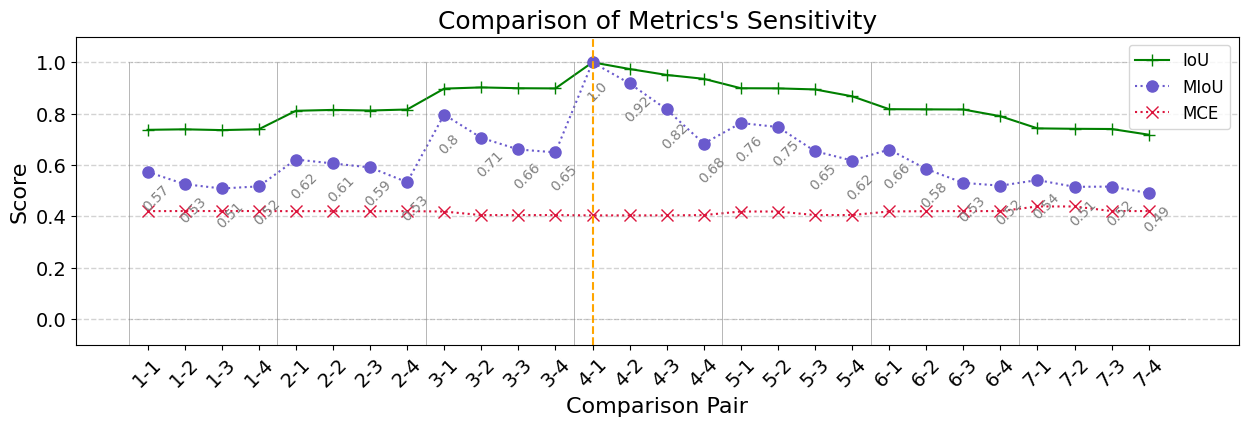

In [45]:
x = np.arange(0, len(all_masks), dtype=int)
areas_c = list(1 - np.array(miou))
areas_c = miou
plots = []
colors = ['green', 'slateblue', 'crimson', 'slateblue', 'crimson']
legend_labels = ['IoU', 'MIoU','MCE']
labels = ['{}-{}'.format(i,j) for i in range(1, n_rows+1) for j in range(1,n_cols+1)]
markers = ['+', 'o', 'x', '1', 's']
linestyles = ['solid', 'dotted', 'dotted', 'solid', 'solid']

ymin = -0.1
ymax = max([max(measures) for measures in measures_list])

fig, ax = plt.subplots(figsize=(15, 4))
for i, measures in enumerate(measures_list):
    plots.append(plt.plot(x, measures,
                          color=colors[i], linestyle=linestyles[i], linewidth=1.5,
                          marker=markers[i], markersize=8,  label=legend_labels[i]))    

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.grid(axis='y', which='both', color='lightgray', linestyle='--', linewidth=1)
plt.ylim(ymin, ymax + 0.1)
plt.vlines(ref_idx, ymin=ymin, ymax=ymax + 0.1, colors='orange', linestyles='--', label='GT')
plt.vlines(x[::4]-0.5, ymin=ymin, ymax=ymax, colors='gray', linestyles='solid', lw=0.4)
plt.hlines(y=0.0, xmin=-0.5, xmax=len(all_masks), colors='gray', linestyles=':', lw=0.4)
plt.hlines(y=1.0, xmin=-0.5, xmax=len(all_masks), colors='gray', linestyles=':', lw=0.4)
plt.title("Comparison of Metrics's Sensitivity", fontsize=18)
plt.xlabel('Comparison Pair', fontsize=16)
plt.ylabel('Score', fontsize=16)


for i in np.arange(len(all_masks)):
    ax.annotate(np.round(areas_c[i], 2), (x[i]-0.2, areas_c[i] - 0.15), color='gray', rotation=45)

plt.legend(legend_labels, fontsize=12)
plt.show()

In [46]:
print(mce)
print(mce_gt_mask_no_edges)

[0.4202305277739434, 0.4206192371611441, 0.4206364251694282, 0.4206190590470686, 0.42007784805600606, 0.42005610842825564, 0.4197653290641699, 0.4202573947425406, 0.41865482620828487, 0.40477671198000925, 0.4048350627110247, 0.4048159612886644, 0.40364945686545206, 0.4036888566437584, 0.40378279388469307, 0.4047637305607819, 0.4187677618173652, 0.4187541756326153, 0.40487434587535137, 0.4049811789777699, 0.41902777267477, 0.41992248630401857, 0.4203596031777261, 0.4203914972323909, 0.4384633873267961, 0.43841622182728807, 0.4204591254671907, 0.42048196763506557]
0.41688850688905815


In [47]:
print(np.var(mce))

8.849291668470535e-05


In [48]:
# Code structure

In [ ]:
def pre_process_masks(mask1, mask2, scale):  # This is the function s in the paper
    # Superimpose a grid over gt and prediction
    return s1, s2

In [ ]:
def pre_process_masks(mask1, mask2, scale):  # This is the function s in the paper
    preprocessor1 = GridBasedSegmentation(mask1, scale)
    s1 = preprocessor1.segmentize()
    preprocessor2 = GridBasedSegmentation(mask2, scale)
    s2 = preprocessor2.segmentize()

    return s1, s2

In [ ]:
def calculate_bce_with_logits(gt, prediction):
    # calculate Cross Entropy in 1 resolution
    return loss

In [ ]:
def calculate_bce_with_logits(gt, prediction, scale):
    # return custom_bce_simplified(gt, prediction)
    # print(prediction)
    # print(gt)
    loss = nn.BCEWithLogitsLoss()
    l = loss(prediction, gt)
    print(l)
    print("-------------------------------------------------------------")
    return l

In [ ]:
def calculate_area(distances, scales):
    # Given the distances (y-coordinates) and scales (x-coordinates) 
    # calculate the area under this curve
    # And normalize scales between [0.1] first
    return area

In [ ]:
def calculate_area(distances, scales):
    # normalized_boxsizes = miou.normalize_boxsizes(scales)
    # slope, _, _, _, _ = linregress(normalized_boxsizes, distances)
    # aiou = np.abs(slope)
    #
    # area = miou.integral_trapezoidal(distances, dx=1 / (len(scales) - 1))
    sd = np.std(scales)
    mean = np.mean(scales)
    normalized_scales = (scales-mean)/sd
    area = simpson(distances, normalized_scales)
    return area

In [ ]:
def MCE(gt, img2, detect_edges = True):

    if detect_edges:
        # Apply filter to only work with edges of the masks
        
    for scale in scales:
        # preprocess gt and prediction masks
        s_gt, s_img2 = pre_process_masks(gt, img2, scale)
        # calculate Cross Entropy (distance between gt and prediction)
        distance = calculate_bce_with_logits(
            torch.tensor(s_gt, dtype=torch.float),
            torch.tensor(s_img2, dtype=torch.float),
            scale)
        distances.append(distance)

    # normalize scales and calculate the area under the curve
    mce = calculate_area(distances, scales)
    return mce

